In [ ]:
!pip install -q transformers torchaudio librosa matplotlib

In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
audio_path = "/content/LJ050-0275.wav"

In [ ]:
import librosa
import torch
import numpy as np

audio_path = "/content/LJ050-0275.wav"
waveform_np, sample_rate = librosa.load(audio_path, sr=None, mono=True)
waveform_np = np.asarray(waveform_np).flatten()
waveform = torch.from_numpy(waveform_np).float()


In [ ]:
target_sr = 16000
if sample_rate != target_sr:
    waveform = torch.from_numpy(
        librosa.resample(waveform.numpy(), orig_sr=sample_rate, target_sr=target_sr)
    ).float()
    sample_rate = target_sr

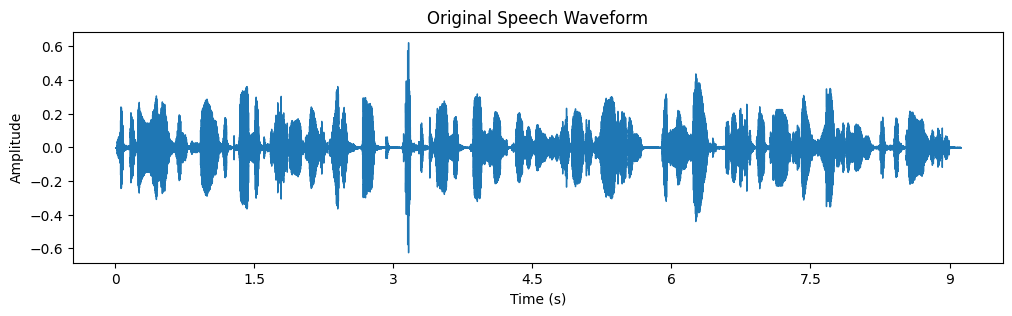

In [ ]:
plt.figure(figsize=(12, 3))
librosa.display.waveshow(waveform.numpy(), sr=sample_rate)
plt.title("Original Speech Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
inputs = processor(
    waveform.numpy(),
    sampling_rate=sample_rate,
    return_tensors="pt",
    padding=True
)
with torch.no_grad():
    logits = model(inputs.input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)
phoneme_seq = processor.decode(predicted_ids[0])
print("Recognized Phonemes / Tokens:")
print(phoneme_seq)


Recognized Phonemes / Tokens:
MATERIALLY IMPROVE UPON THE PRECEDURES INEFFECT AT THE TIME OF PRESIDENT KENNEDY'S ASSASSINATION AND RESULT IN A SUBSTANTIAL LESSENING OF THE DANGER


In [ ]:
tokens = phoneme_seq.split()
num_tokens = len(tokens)

duration = len(waveform) / sample_rate
time_per_token = duration / num_tokens

intervals = []
for i, token in enumerate(tokens):
    start = i * time_per_token
    end = (i + 1) * time_per_token
    intervals.append((token, start, end))

intervals[:5]


[('MATERIALLY', 0.0, 0.4145909090909091),
 ('IMPROVE', 0.4145909090909091, 0.8291818181818182),
 ('UPON', 0.8291818181818182, 1.2437727272727273),
 ('THE', 1.2437727272727273, 1.6583636363636365),
 ('PRECEDURES', 1.6583636363636365, 2.0729545454545457)]

In [ ]:
phoneme_index = 3
label, start_t, end_t = intervals[phoneme_index]
start_sample = int(start_t * sample_rate)
end_sample = int(end_t * sample_rate)
phoneme_wave = waveform[start_sample:end_sample]


In [ ]:
import soundfile as sf

sf.write(
    f"phoneme_{label}.wav",
    phoneme_wave.numpy(),
    sample_rate
)

print(f"Saved: phoneme_{label}.wav")


Saved: phoneme_THE.wav


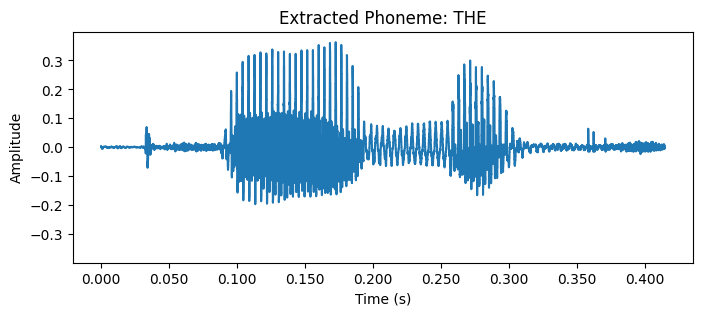

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(8, 3))
librosa.display.waveshow(phoneme_wave.numpy(), sr=sample_rate)
plt.title(f"Extracted Phoneme: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
print(f"""
Inference for phoneme '{label}':

- If waveform is periodic → vowel (voiced)
- If waveform is noise-like → fricative
- If waveform has sharp burst → plosive
- If waveform has low-energy resonance → nasal

Thus, the sound source depends on airflow and vocal cord vibration.
""")



Inference for phoneme 'THE':

- If waveform is periodic → vowel (voiced)
- If waveform is noise-like → fricative
- If waveform has sharp burst → plosive
- If waveform has low-energy resonance → nasal

Thus, the sound source depends on airflow and vocal cord vibration.

